In [1]:
using MLDatasets
using Flux
using Images
include("unet.jl")
include("utils.jl")

check_filters (generic function with 1 method)

# Get data and preprocess

In [2]:
?MNIST.traindata

```
traindata([T = N0f8], [indices]; [dir]) -> Tuple
```

Returns the MNIST **trainingset** corresponding to the given `indices` as a two-element tuple. If `indices` is omitted the full trainingset is returned. The first element of three return values will be the images as a multi-dimensional array, and the second element the corresponding labels as integers.

The image(s) is/are returned in the horizontal-major memory layout as a single numeric array of eltype `T`. If `T <: Integer`, then all values will be within `0` and `255`, otherwise the values are scaled to be between `0` and `1`. The integer values of the labels correspond 1-to-1 the digit that they represent.

```julia
train_x, train_y = MNIST.traindata() # full datatset
train_x, train_y = MNIST.traindata(2) # only second observation
train_x, train_y = MNIST.traindata(dir="./MNIST") # custom folder
```

The corresponding resource file(s) of the dataset is/are expected to be located in the specified directory `dir`. If `dir` is omitted the directories in `DataDeps.default_loadpath` will be searched for an existing `MNIST` subfolder. In case no such subfolder is found, `dir` will default to `~/.julia/datadeps/MNIST`. In the case that `dir` does not yet exist, a download prompt will be triggered. You can also use `MNIST.download([dir])` explicitly for pre-downloading (or re-downloading) the dataset. Please take a look at the documentation of the package DataDeps.jl for more detail and configuration options.

Take a look at [`MNIST.traintensor`](@ref) and [`MNIST.trainlabels`](@ref) for more information.


In [3]:
(train_x, _), (test_x, _) = MNIST.traindata(), MNIST.testdata();

####  check if there is probelm with filter sizes

In [34]:
check_filters(28,4,2,1) # no problem for unet with depth 2 then it will not reconstruct original image

input shape->28
output -> 14.0 -> after floor -> 14.0 
output -> 7.0 -> after floor -> 7.0 
output -> 3.5 -> after floor -> 3.0  -> problem
output -> 1.5 -> after floor -> 1.0  -> problem


In [35]:
check_filters(32,4,2,1) # not problem for unet to depth 5

input shape->32
output -> 16.0 -> after floor -> 16.0 
output -> 8.0 -> after floor -> 8.0 
output -> 4.0 -> after floor -> 4.0 
output -> 2.0 -> after floor -> 2.0 
output -> 1.0 -> after floor -> 1.0 


#### Preprocess MNIST and resize it from 28x28 -> 32x32

In [6]:
h,w,N = size(train_x)

(28, 28, 60000)

In [7]:
h,w,Nₜ = size(test_x)

(28, 28, 10000)

In [8]:
train_x, test_x = float(train_x), float(test_x)
train_x, test_x = imresize(train_x, 32, 32, N), imresize(test_x, 32, 32, Nₜ)
train_x, test_x = reshape(train_x, (32, 32, 1, :)), reshape(test_x, (32, 32, 1, :))  
size(train_x)

(32, 32, 1, 60000)

In [9]:
train_x = Flux.Data.DataLoader(train_x, batchsize=64, shuffle=true);

In [10]:
idx = rand(1:size(test_x,4), 64) # jsut for very quick test of convergence
val_x = test_x[:,:,:,idx];
size(val_x)

(32, 32, 1, 64)

# Define model

In [50]:
kernel = 4 
in_ch = 1 # mnist has one channel
nf = 32
sf = 6

unet = UnetBlock(nf, kernel, nf, sf, layer_type="bottom")
unet = UnetBlock(nf, kernel, nf, sf, sub_level=unet, layer_type="middle")
unet = UnetBlock(nf, kernel, nf, sf, sub_level=unet, layer_type="middle") 
unet = UnetBlock(in_ch, kernel, nf, sf, sub_level=unet, layer_type="top") 
unet = Flux.Chain(unet, x->sigmoid.(x))

unet = unet |> gpu

Chain(UnetBlock(Chain(Chain(Conv((4, 4), 1=>32), BatchNorm(32)), UnetBlock(Chain(Chain(#47, Conv((4, 4), 32=>32), BatchNorm(32)), UnetBlock(Chain(Chain(#47, Conv((4, 4), 32=>32), BatchNorm(32)), UnetBlock(Chain(Chain(#44, Conv((4, 4), 32=>32), BatchNorm(32)), #51, Chain(#45, ConvTranspose((4, 4), 32=>32), BatchNorm(32))), true, Chain(Conv((3, 3), 32=>6), BatchNorm(6), #46)), Chain(#48, ConvTranspose((4, 4), 38=>32), BatchNorm(32))), true, Chain(Conv((3, 3), 32=>6), BatchNorm(6), #49)), Chain(#48, ConvTranspose((4, 4), 38=>32), BatchNorm(32))), true, Chain(Conv((3, 3), 32=>6), BatchNorm(6), #49)), Chain(#43, ConvTranspose((4, 4), 38=>1))), false, nothing), #61)

# Training

In [51]:
loss(x) = Flux.Losses.mse(unet(x|>gpu), x|>gpu)
params = Flux.params(unet)
opt = Flux.ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [52]:
evalcb() = @show(loss(val_x))

evalcb (generic function with 1 method)

In [53]:
Flux.train!(loss, params, train_x, opt, cb = Flux.throttle(evalcb, 10)) # 1 epoch

loss(val_x) = 0.22032717f0
loss(val_x) = 0.0014878528f0
loss(val_x) = 0.0009694868f0


In [68]:
Flux.testmode!(unet)

Chain(UnetBlock(Chain(Chain(Conv((4, 4), 1=>32), BatchNorm(32)), UnetBlock(Chain(Chain(#47, Conv((4, 4), 32=>32), BatchNorm(32)), UnetBlock(Chain(Chain(#47, Conv((4, 4), 32=>32), BatchNorm(32)), UnetBlock(Chain(Chain(#44, Conv((4, 4), 32=>32), BatchNorm(32)), #51, Chain(#45, ConvTranspose((4, 4), 32=>32), BatchNorm(32))), true, Chain(Conv((3, 3), 32=>6), BatchNorm(6), #46)), Chain(#48, ConvTranspose((4, 4), 38=>32), BatchNorm(32))), true, Chain(Conv((3, 3), 32=>6), BatchNorm(6), #49)), Chain(#48, ConvTranspose((4, 4), 38=>32), BatchNorm(32))), true, Chain(Conv((3, 3), 32=>6), BatchNorm(6), #49)), Chain(#43, ConvTranspose((4, 4), 38=>1))), false, nothing), #61)

In [69]:
x̂ = unet(test_x[:,:,:,1:10]|>gpu);

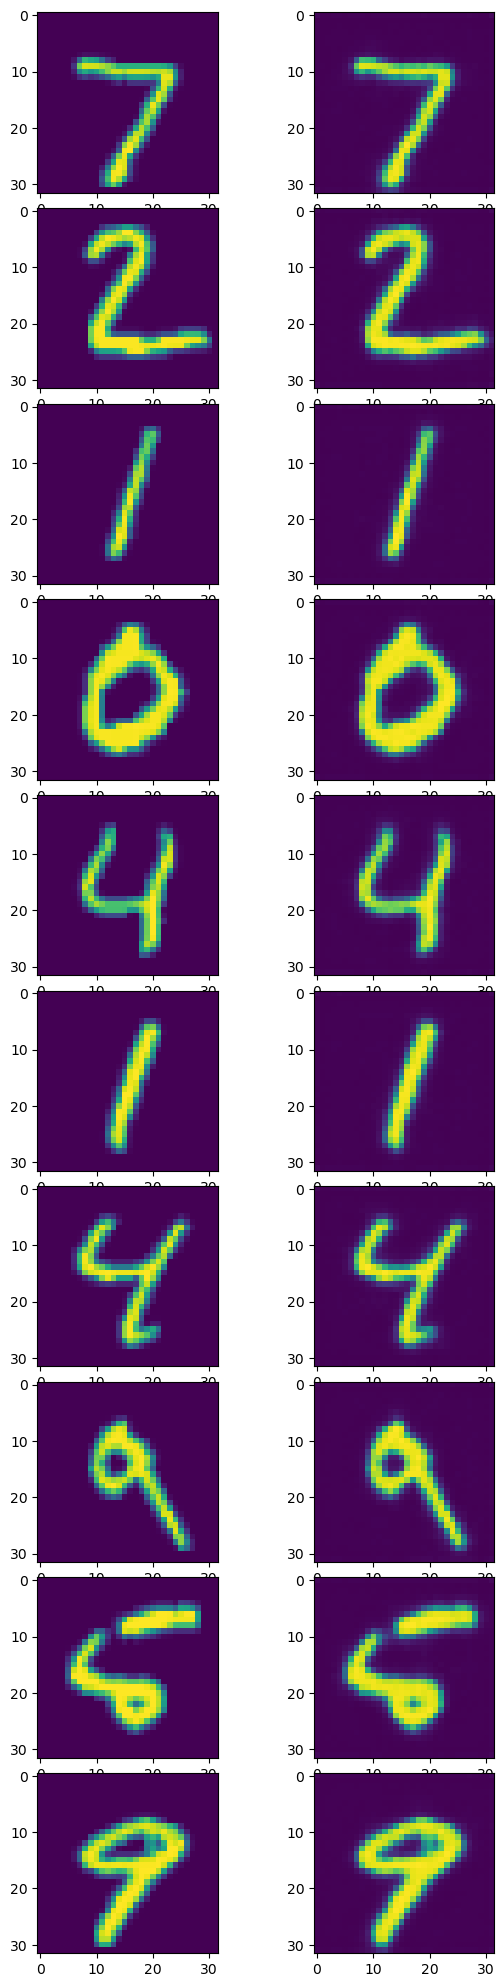

In [111]:
fig,ax = subplots(10,2, figsize=(10,20))
fig.tight_layout(w_pad=-30, h_pad=-1)
for i = 1:10
    ax[i,1].imshow(test_x[:,:,1,i]')
    ax[i,2].imshow(x̂[:,:,1,i]'|>cpu)
end
# left original images, right reconstructed images => 4 layer unet is to much for MNIST :D